# KNN Regressor using Wi-Fi Experiments

<p>Jupyter Notebook which aims to explore the ML algorithm K-Nearest Neighbors as a Regression algorithm using the Wi-Fi technology moreover using the strength of the signal as a basis. </p>

## Imports
Imports of the libraries to be used throughout the experiments

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

## Load File and Structure Data Function
Function to load csv and structure data accordingly

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

## Initialize Training Data

In [3]:
dataset = load_file('radiomapBluetooth.csv')
X_train = dataset.iloc[:,3:]
Y_train = dataset.iloc[:,1:3]

## Radio Map Graphical Display

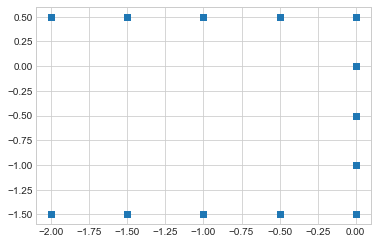

In [4]:
x , y = map(list, zip(*Y_train.values)) 
fig = plt.figure()
ax = plt.axes()
plt.plot(x,y,'s')

## Access Points Graphical Display
Graphical display with the average strength signal transmitted by each access point

<BarContainer object of 3 artists>

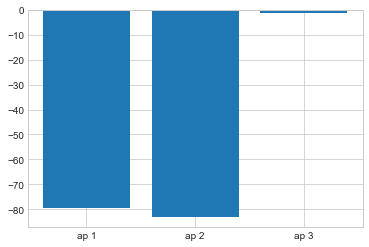

In [5]:
count_aps = {}
counter = 1
for ap in X_train:
    mean_value = dataset[ap].mean()
    count_aps['ap ' + str(counter)] = mean_value
    counter = counter + 1
plt.bar(range(len(count_aps)),list(count_aps.values()),align='center',tick_label=list(count_aps.keys()))

## Number of Fingerprints per Reference Point Graphical Display
Graphical display of the number of fingerprints retrieved at each reference point

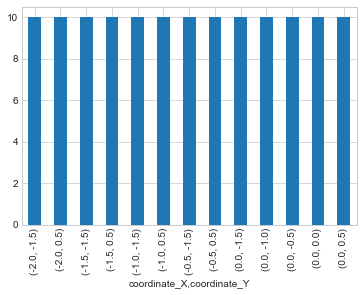

In [6]:
reference_points = dataset.groupby(['coordinate_X','coordinate_Y'])
reference_points.size().plot(kind="bar")

## Signal Strength Distribution Display
Graphical display of the distribution of the signal strength

Text(0, 0.5, 'Probability')

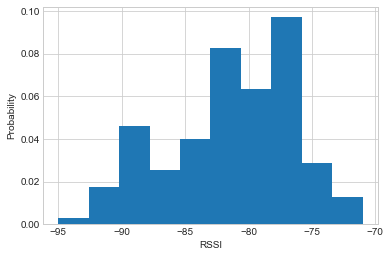

In [7]:
flatten_results = X_train.values.flatten().tolist()
flatten_results = list(filter((0).__ne__,flatten_results))
plt.hist(flatten_results,density=True)
plt.xlabel('RSSI')
plt.ylabel('Probability')

## Initialize KNN Parameters arrays
Initialization of the arrays with the different possible values for the parameters of KNN Regression function

In [8]:
#Knn Configurable parameters arary
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis","minkowski"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
filters = ["Median","Mean","No Filter"]
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler()]
weights = ["uniform","distance"]
default_data_scenario = Y_train.copy()
default_data_scenario_groups = default_data_scenario["coordinate_X"].map(str)+","+default_data_scenario["coordinate_Y"].map(str)
#Test data from separate csv file
test_dataset_from_file = load_file('testdata.csv')
X_test_from_file = test_dataset_from_file.iloc[:,3:]
Y_test_from_file = test_dataset_from_file.iloc[:,1:3]

## Statistics Output Format
Structure of the statistical output of each call to the KNN Regression Function

In [9]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

## Configurable KNN Regression Function 
Configurable function to aplpy the knn to a training set

In [10]:
def compute_KNN_with_Regression(trainX_data = None,trainY_data = None,testX_data = None,testY_data = None,scaler = None,cross_validation = None,n_neighbors=5,
                                weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1):
    # Init the KNN Regressor Estimator
    knn_regression_estimator = KNeighborsRegressor(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_regression_estimator)
    else:
        main_estimator = knn_regression_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the training features
        predict_train = main_estimator.predict(trainX_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_data_scenario_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    # Structure data to statistics
    statistical_array = list()
    coord_cols = ['coordinate_X','coordinate_Y']
    predictions = pd.DataFrame(predict_test,columns=coord_cols)
    result = testY_data.join(predictions, rsuffix="_predicted")
    observed_errors = predictions[coord_cols] - result[coord_cols]
    error = pd.DataFrame(observed_errors.apply(np.linalg.norm, axis=1), columns=["error"])
    result = pd.concat([result,error], axis = 1)
    return structure_data(result,coefficient_determination)

## Experiments

### 1st Experiment - Running KNN function with default parameters and testing data equal to training data

In [11]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_KNN_with_Regression(trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.722562,0.697231,0.835003,0.42011,0.412311,0.640312,0.894427,1.614155,0.0,1.835756,0.517187


### 2nd Experiment - Running KNN function with default parameters and testing data from separate file

In [12]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
#result = compute_KNN_with_Regression(trainX_data=X_train,trainY_data=Y_train,testX_data=X_test_from_file,testY_data=Y_test_from_file,scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.722562,0.697231,0.835003,0.42011,0.412311,0.640312,0.894427,1.614155,0.0,1.835756,0.517187


### 3rd Experiment - Finding the best k parameter with Grid Search

In [13]:
def grid_search():
    skf = StratifiedKFold(n_splits=10)
    splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    knn_regressor_estimator = KNeighborsRegressor() #init knn regressor estimator
    k_range = list(range(1, 31))
    param_grid = {'knn__n_neighbors': k_range}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_regressor_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=splited,scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,
                                                        greater_is_better=False,
                                                        multioutput="uniform_average"))
    #fit model to data
    estimator.fit(X_train.values, Y_train.values)
    print(estimator.best_params_)
    return estimator.best_params_['knn__n_neighbors']


In [14]:
best_knn = grid_search()

{'knn__n_neighbors': 25}


### 4th Experiment - Graphical Display of k accuracy

In [15]:
def find_fit_k():
    skf = StratifiedKFold(n_splits=10)
    splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    knn_regressor_estimator = KNeighborsRegressor() #init knn regressor estimator
    k_range = list(range(1, 31))
    param_grid = {'knn__n_neighbors': k_range}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_regressor_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=splited,scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,
                                                        greater_is_better=False,
                                                        multioutput="uniform_average"))
    #fit model to data
    estimator.fit(X_train.values, Y_train.values)
    grid_mean_scores = estimator.cv_results_['mean_test_score']
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-validated accuracy')

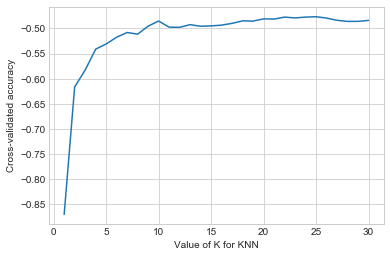

In [16]:
find_fit_k()

### 5th Experiment - Running the KNN function with default parameters and Hold-out Cross Validation

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size
4,0.860384,0.957846,0.978696,0.470090,0.447214,0.806226,1.104536,1.780368,0.000000,1.886796,0.324921,0.5
1,0.862211,0.954231,0.976847,0.468248,0.525000,0.728011,1.054762,1.611424,0.223607,2.193171,0.315781,0.2
3,0.868377,0.990000,0.994987,0.490457,0.486803,0.824621,1.118034,1.809960,0.100000,1.886796,0.301231,0.4
2,0.920989,1.096923,1.047341,0.505221,0.500000,0.854400,1.120637,1.793545,0.100000,1.860108,0.238923,0.3
0,0.985500,1.255385,1.120439,0.554848,0.600000,0.800000,1.115270,2.023567,0.400000,2.193171,0.098045,0.1


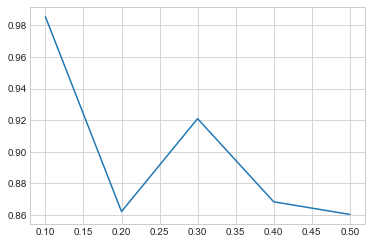

In [17]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes = [0.1,0.2,0.3,0.4,0.5]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
    X_train_split = X_train_split.reset_index(drop=True)
    X_test_split = X_test_split.reset_index(drop=True)
    y_train_split = y_train_split.reset_index(drop=True)
    y_test_split = y_test_split.reset_index(drop=True)
    result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['test_size'],statistics['mae'])

### 6th Experiment - Running the KNN function with default parameters and K-Fold cross validation

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
5,1.156082,1.608769,1.268373,0.523787,0.800000,1.100000,1.442221,2.138269,0.223607,2.332381,-0.118491,10
4,1.182244,1.638308,1.279964,0.492415,0.800000,1.204159,1.416330,2.138269,0.141421,2.332381,-0.142747,9
3,1.209473,1.677615,1.295228,0.465248,0.894427,1.210356,1.442221,2.016795,0.223607,2.282542,-0.166415,8
2,1.298117,1.960615,1.400220,0.526920,0.948683,1.290312,1.627882,2.138269,0.316228,2.332381,-0.362885,7
1,1.361457,2.180923,1.476795,0.574366,0.868781,1.398203,1.704697,2.236068,0.100000,2.500000,-0.509064,6
0,1.428020,2.361692,1.536780,0.570044,1.044031,1.442221,1.756632,2.236068,0.316228,2.500000,-0.624838,5


Number of Folds:  10


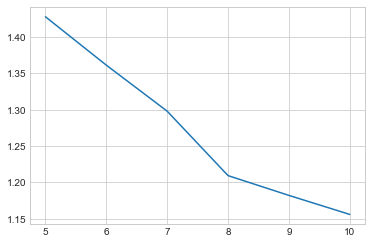

In [18]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(5,11)
results = list()
for cv in cross_validation_list:
    kf = KFold(n_splits=cv)
    splited = kf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Default Stratified KFold

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
1,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.272050,6
5,0.887228,1.054385,1.026832,0.518924,0.500000,0.724561,1.131371,1.986048,0.1,2.282542,0.269070,10
4,0.888623,1.042615,1.021085,0.504902,0.500000,0.724561,1.131371,1.986048,0.1,2.282542,0.276897,9
0,0.890977,1.053615,1.026458,0.511654,0.460410,0.780789,1.170470,1.927631,0.1,2.282542,0.268153,5
2,0.893451,1.058385,1.028778,0.512002,0.460410,0.724561,1.122035,1.916965,0.1,2.282542,0.265242,7
3,0.902711,1.077923,1.038231,0.514855,0.500000,0.724561,1.170470,2.007596,0.1,2.282542,0.249964,8


Number of Folds:  6


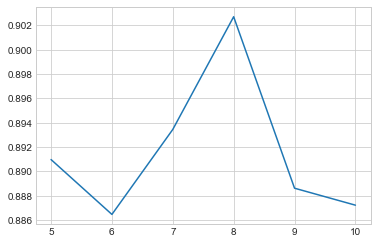

In [19]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(5,11)
results = list()
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

### Compare K-Fold strategies

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method
1,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.272050,Stratified K-Fold
0,1.361457,2.180923,1.476795,0.574366,0.868781,1.398203,1.704697,2.236068,0.1,2.500000,-0.509064,K-fold


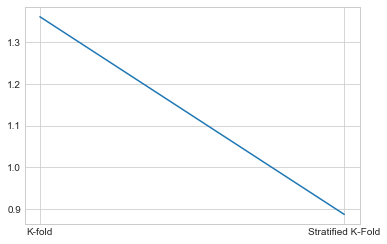

In [20]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method']
results = list()
kf = KFold(n_splits=selected_fold)
splited = kf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
kfold = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
kfold.append('K-fold')
results.append(kfold)
skf = StratifiedKFold(n_splits=selected_fold)
splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
skfold = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)
skfold.append('Stratified K-Fold')
results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'])

### 7th Experiment -  Running the KNN function with default parameters and Leave One Out cross validation

In [21]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
loo = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,1.180597,1.637462,1.279633,0.49552,0.818269,1.1,1.41633,2.176827,0.141421,2.332381,-0.135483


### Compare cross validation methods

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method
3,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.100000,2.282542,0.272050,Stratified K-Fold
1,1.180597,1.637462,1.279633,0.495520,0.818269,1.100000,1.416330,2.176827,0.141421,2.332381,-0.135483,LOO
2,1.261526,1.760909,1.326992,0.431749,0.978721,1.280625,1.456022,1.851249,0.565685,2.002498,0.238923,HoldOut
0,1.361457,2.180923,1.476795,0.574366,0.868781,1.398203,1.704697,2.236068,0.100000,2.500000,-0.509064,K-Fold


Selected cross validation method:  Stratified K-Fold


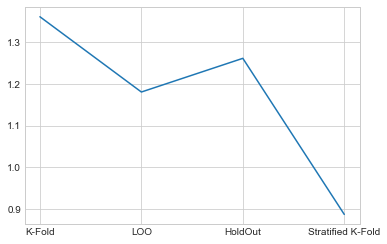

In [22]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method']
results = list()
kf = KFold(n_splits=selected_fold)
splited = kf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
kfold = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train,Y_train, test_size = 0.3, random_state = 6,stratify=Y_train)
X_train_split = X_train_split.reset_index(drop=True)
X_test_split = X_test_split.reset_index(drop=True)
y_train_split = y_train_split.reset_index(drop=True)
y_test_split = y_test_split.reset_index(drop=True)
holdout = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler())
kfold.append('K-Fold')
results.append(kfold)
loo.append('LOO')
results.append(loo)
holdout.append('HoldOut')
results.append(holdout)
skf = StratifiedKFold(n_splits=selected_fold)
splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
skfold = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)
skfold.append('Stratified K-Fold')
results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'])
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

### 9th Experiment - Running the KNN function with the different weights

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,weights
0,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.27205,uniform
1,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.27205,distance


Selected weight:  uniform


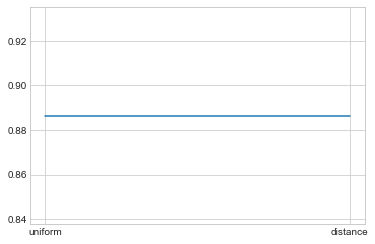

In [23]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','weights']
results = list()
for weight in weights:
    if selected_method == 'K-Fold':
        kf = KFold(n_splits=selected_fold)
        splited = kf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                           weights = weight)
    elif selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                           weights = weight)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                           weights = weight)
    result.append(weight)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

### 10th Experiment - Running the KNN function with the different preprocessing methods

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,preprocessing,preprocessingFunc
1,0.882117,1.043846,1.021688,0.517470,0.447214,0.806226,1.112587,1.893997,0.1,2.267157,0.272952,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))"
2,0.883603,1.051385,1.025370,0.522234,0.412311,0.824621,1.109411,1.863828,0.1,2.282542,0.270303,MaxAbsScaler,MaxAbsScaler(copy=True)
0,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.272050,StandardScaler,"StandardScaler(copy=True, with_mean=True, with..."


Selected Preprocessing:  MinMaxScaler


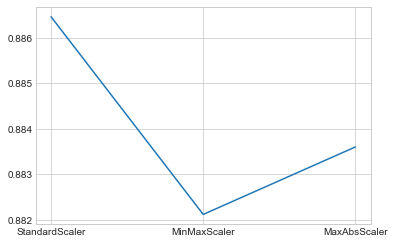

In [24]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc']
results = list()
for preprocess in scaler:
    if selected_method == 'K-Fold':
        kf = KFold(n_splits=selected_fold)
        splited = kf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)
    elif selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocess)
    regex = re.search('(\w+)\(',str(preprocess)).group(1)
    result.append(regex)
    result.append(preprocess)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### 11th Experiment - Running the KNN function with the different algorithms

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,algorithms
0,0.881201,1.030385,1.015079,0.505803,0.460410,0.724561,1.143101,1.893997,0.1,2.282542,0.284135,brute
2,0.886165,1.048231,1.023831,0.514762,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.272443,ball_tree
1,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.272050,kd_tree
3,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.272050,auto


Selected Algorithm:  brute


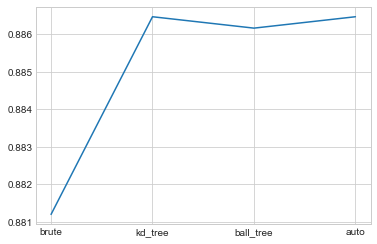

In [25]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','algorithms']
results = list()
for algorithm in algorithms:
    if selected_method == 'K-Fold':
        kf = KFold(n_splits=selected_fold)
        splited = kf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            algorithm = algorithm)
    elif selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            algorithm = algorithm)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            algorithm = algorithm)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            algorithm = algorithm)
    result.append(algorithm)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['algorithms'],statistics['mae'])
selected_algorithm = statistics.sort_values(by=['mae'])['algorithms'].head(1).values[0]
print("Selected Algorithm: ",selected_algorithm)

### 12th Experiment - Running the KNN function with the different distance metrics

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,distance
3,0.874827,1.030923,1.015344,0.517358,0.460410,0.721110,1.049726,1.837253,0.0,2.332381,0.281202,braycurtis
1,0.883718,1.051077,1.025220,0.521741,0.500000,0.741344,1.118034,1.987407,0.1,2.332381,0.269516,manhattan
0,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.272050,euclidean
4,0.886469,1.048462,1.023944,0.514462,0.447214,0.764005,1.122035,1.893997,0.1,2.282542,0.272050,minkowski
2,0.890012,1.066000,1.032473,0.525359,0.421036,0.806226,1.140175,2.071757,0.1,2.332381,0.254745,canberra


Selected Distance Metric:  braycurtis


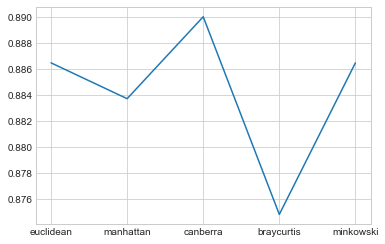

In [26]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','distance']
results = list()
for distance in distance_metris:
    if selected_method == 'K-Fold':
        kf = KFold(n_splits=selected_fold)
        splited = kf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            metric = distance)
    elif selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            metric = distance)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            metric = distance)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            metric = distance)
    result.append(distance)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['distance'],statistics['mae'])
selected_distance_metric = statistics.sort_values(by=['mae'])['distance'].head(1).values[0]
print("Selected Distance Metric: ",selected_distance_metric)

### 13th Experiment: Run with every configurable parameters and let the program decide the best parameters
Match these with the previously settled.

In [27]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','distance','preprocessing','weights']
results = list()
k_range = range(1, 31)
for distance in distance_metris:
    for preprocessing in scaler:
        for weight in weights:
            if selected_method == 'K-Fold':
                kf = KFold(n_splits=selected_fold)
                splited = kf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
                result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = splited,
                                        metric = distance,weights=weight)
            elif selected_method == 'LOO':
                cv = LeaveOneGroupOut()
                splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
                result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = splited,
                                                    metric = distance,weights=weight)  
            elif selected_method =='Stratified K-Fold':
                skf = StratifiedKFold(n_splits=selected_fold)
                splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
                result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = splited,
                                                    metric = distance,weights=weight)
            else:
                result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocessing,
                                                    metric = distance,weights=weight)
            result.append(distance)
            regex = re.search('(\w+)\(',str(preprocessing)).group(1)
            result.append(regex)
            result.append(weight)
            results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,distance,preprocessing,weights
21,0.833047,1.113546,1.055247,0.650254,0.293581,0.746959,1.030776,2.112631,0.0,2.283801,0.220925,braycurtis,MinMaxScaler,distance
11,0.837285,1.117048,1.056905,0.647477,0.331782,0.730984,1.030776,2.061553,0.0,2.318099,0.215456,manhattan,MaxAbsScaler,distance
27,0.837436,1.097523,1.047627,0.631899,0.357505,0.763664,1.030776,2.046928,0.0,2.253461,0.226863,minkowski,MinMaxScaler,distance
3,0.837436,1.097523,1.047627,0.631899,0.357505,0.763664,1.030776,2.046928,0.0,2.253461,0.226863,euclidean,MinMaxScaler,distance
9,0.838564,1.117816,1.057268,0.646406,0.334130,0.746529,1.030776,2.113089,0.0,2.283631,0.216871,manhattan,MinMaxScaler,distance
13,0.839210,1.122698,1.059575,0.649360,0.355062,0.728702,1.033822,2.127166,0.0,2.287105,0.212343,canberra,StandardScaler,distance
19,0.841153,1.126821,1.061518,0.650025,0.356906,0.717136,1.033672,2.112489,0.0,2.356827,0.208304,braycurtis,StandardScaler,distance
25,0.841811,1.107724,1.052485,0.634171,0.367325,0.739563,1.030776,2.046889,0.0,2.290796,0.221144,minkowski,StandardScaler,distance
1,0.841811,1.107724,1.052485,0.634171,0.367325,0.739563,1.030776,2.046889,0.0,2.290796,0.221144,euclidean,StandardScaler,distance
17,0.843561,1.139917,1.067669,0.656994,0.322369,0.727609,1.030776,2.110772,0.0,2.358759,0.199581,canberra,MaxAbsScaler,distance


### 14th Experiment: Running the KNN function with data filtered 

In [28]:
def apply_filter():
    statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','filter']
    results = list()
    for filterelement in filters:
        if filterelement == 'Median':
            result = apply_median_filter()
        elif filterelement == 'Mean':
            result = apply_mean_filter()
        else:
            result = compute_KNN_with_Regression(trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
            result.append('No Filter')
        results.append(result)
    statistics = pd.DataFrame(columns=statistical_cols,data=results)
    display(statistics.sort_values(by=['mae']))
    plt.plot(statistics['filter'],statistics['mae'])
    selected_filter = statistics.sort_values(by=['mae'])['filter'].head(1).values[0]
    print("Selected Filter: ",selected_filter)
    return selected_filter
            

def apply_median_filter():
    medians = list()
    aps = ['coordinate_X','coordinate_Y']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        x = rp[0]
        y = rp[1]
        medians_list = [x,y]
        for ap in X_train:
            median = access_points[ap].median()
            medians_list.append(median)
        medians.append(medians_list)
    median_pd = pd.DataFrame(medians,columns = aps)
    x_train = median_pd.iloc[:,2:]
    y_train = median_pd.iloc[:,:2]
    result = compute_KNN_with_Regression(trainX_data=x_train,trainY_data=y_train,testX_data=x_train,testY_data=y_train,scaler=StandardScaler(),metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
    result.append('Median')
    return result

def apply_mean_filter(): 
    means = list()
    aps = ['coordinate_X','coordinate_Y']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        x = rp[0]
        y = rp[1]
        means_list = [x,y]
        for ap in X_train:
            mean = access_points[ap].mean()
            means_list.append(mean)
        means.append(means_list)
    mean_pd = pd.DataFrame(means,columns = aps)
    x_train = mean_pd.iloc[:,2:]
    y_train = mean_pd.iloc[:,:2]
    result = compute_KNN_with_Regression(trainX_data=x_train,trainY_data=y_train,testX_data=x_train,testY_data=y_train,scaler=StandardScaler(),metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
    result.append('Mean')
    return result

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,filter
2,0.733367,0.719231,0.848075,0.427563,0.412311,0.700000,0.894427,1.634080,0.000000,1.835756,0.501800,No Filter
0,0.767858,0.703077,0.838497,0.350609,0.412311,0.721110,0.936656,1.322496,0.316228,1.500000,0.524822,Median
1,0.881638,0.901538,0.949494,0.366889,0.761577,0.905539,1.025206,1.358947,0.141421,1.500000,0.397388,Mean


Selected Filter:  No Filter


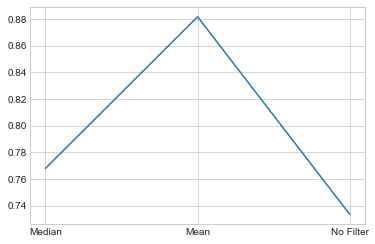

In [29]:
selected_filter = apply_filter()

## Results Analysis and Conclusion
Analysis of the outcomes of the different experiments and final conclusions.

In [30]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance','Filtering']
conclusion_list = [best_knn,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance_metric,selected_filter]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,K Parameter,Cross Validation,Weight,Preprocessing,Algorithm,Distance,Filtering
0,25,Stratified K-Fold,uniform,MinMaxScaler,brute,braycurtis,No Filter


#### Best Result

In [31]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
if selected_method == 'K-Fold':
    kf = KFold(n_splits=selected_fold)
    splited = kf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(n_neighbors=best_knn,testX_data=X_train,testY_data=Y_train,scaler=selected_preprocesssing_func,cross_validation = splited,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)
elif selected_method == 'LOO':
    cv = LeaveOneGroupOut()
    splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(n_neighbors=best_knn,testX_data=X_train,testY_data=Y_train,scaler=selected_preprocesssing_func,cross_validation = splited,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)  
elif selected_method =='Stratified K-Fold':
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(n_neighbors=best_knn,testX_data=X_train,testY_data=Y_train,scaler=selected_preprocesssing_func,cross_validation = splited,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)  
else:
    result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=selected_preprocesssing_func,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.898833,0.953606,0.976528,0.383189,0.62538,0.893958,1.074362,1.578369,0.072111,1.84954,0.332569
